In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np

cle.select_device('RTX')

<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (1 refs)>

In [2]:
# Configure data source
filename = 'C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR/stacks/C0opticsprefused/001200.raw'
width = 512
height = 1024
depth = 71
voxel_size = [3, 0.6934, 0.6934]

In [3]:
%gui qt

In [4]:
import napari

# create Qt GUI context
napari.gui_qt()

# convenience methods
def show(image, labels=False, title=None, use_napari=False):
    if len(image.shape) == 3:
        # print(image.shape)
        max_projection = cle.create([image.shape[1], image.shape[2]])
        cle.maximum_z_projection(image, max_projection)
        cle.imshow(cle.transpose_xy(max_projection), labels=labels, min_display_intensity=0)
    else:
        cle.imshow(cle.transpose_xy(image), labels=labels, min_display_intensity=0)    
    
    if use_napari:
        if show.viewer is None:
            show.viewer = napari.Viewer()
            
        if labels:
            show.viewer.add_labels(cle.pull_zyx(image), name=title)
        else:
            show.viewer.add_image(cle.pull_zyx(image), name=title)
            
show.viewer = None

In [5]:
# load and resample
img_arr = bs.imread_raw(filename, width, height, depth)
buffer = cle.push_zyx(img_arr)
resampled = cle.resample(buffer, factor_x = voxel_size[2], factor_y = voxel_size[1], factor_z = voxel_size[0])
input = cle.pull_zyx(resampled)

------------------------
imread_raw took 0.031458377838134766


# Segmentation

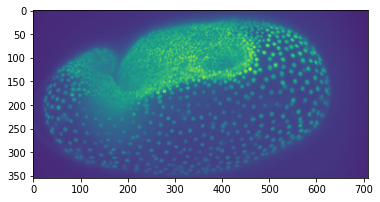

In [6]:
show(resampled, title="original", use_napari=True)

subtract background took 0.13454055786132812


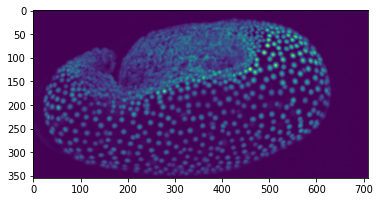

In [7]:
background_subtracted = None
background_subtracted = bs.background_subtraction(resampled, background_subtracted, 2, 7)
show(background_subtracted, title="background subtracted", use_napari=True)

Num spots: 1789.0
spot detection took 0.09336113929748535
1789.0
cell segmentation took 0.12096738815307617


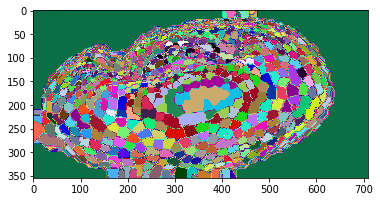

In [8]:
spots = cle.create_like(background_subtracted) 
spots = bs.spot_detection(background_subtracted, spots, threshold=10)

print(cle.maximum_of_all_pixels(spots))


cells = cle.create_like(spots)
cells = bs.cell_segmentation(spots, cells, number_of_dilations=14, number_of_erosions=8)
show(cells, title="cells", use_napari=True, labels=True)

# Quantiative analysis

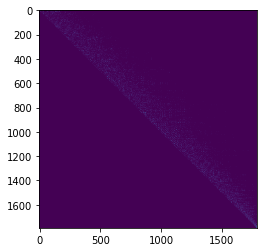

In [9]:
touch_matrix = cle.generate_touch_matrix(cells)

# ignor touching the background
cle.set_column(touch_matrix,0,0)
cle.set_row(touch_matrix,0,0)

show(touch_matrix)

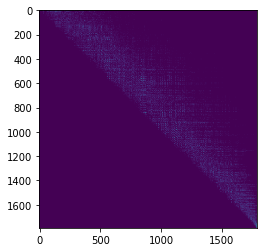

In [10]:
neighbors_of_neighbors = cle.neighbors_of_neighbors(touch_matrix)
show(neighbors_of_neighbors)

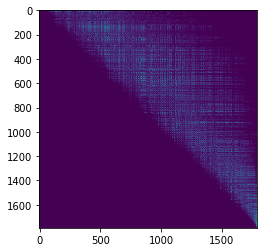

In [11]:
neighbors_of_neighbors_of_neighbors = cle.neighbors_of_neighbors(neighbors_of_neighbors)
show(neighbors_of_neighbors_of_neighbors)

(3, 1789)


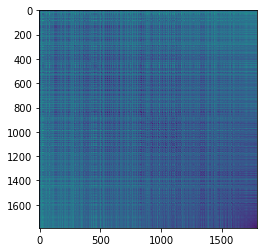

In [12]:
pointlist = cle.labelled_spots_to_pointlist(spots)
print(pointlist.shape)
distance_matrix = cle.generate_distance_matrix(pointlist, pointlist)
show(distance_matrix)

## Measure average neigbor distance

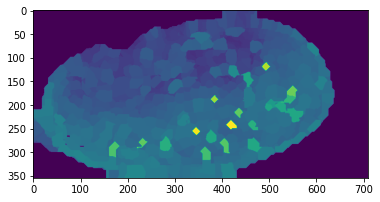

In [13]:
nearest_neighbor_distance = cle.average_distance_of_n_closest_points(distance_matrix, n=6)

nn_distance_map = cle.replace_intensities(cells, nearest_neighbor_distance)
show(nn_distance_map, title="distance map", use_napari=True)


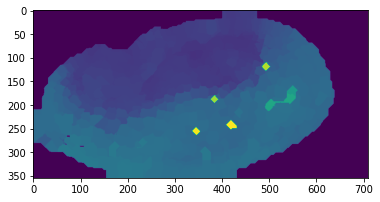

In [14]:
local_nearest_neighbor_distance = cle.median_of_touching_neighbors(nearest_neighbor_distance, neighbors_of_neighbors)

nn_distance_map = cle.replace_intensities(cells, local_nearest_neighbor_distance)
show(nn_distance_map, title="local median distance map", use_napari=True)


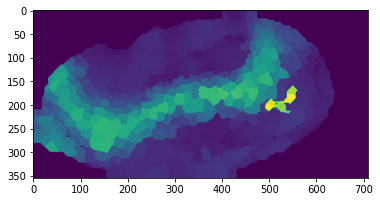

In [15]:
local_stddev_nearest_neighbor_distance = cle.standard_deviation_of_touching_neighbors(local_nearest_neighbor_distance, neighbors_of_neighbors)

nn_distance_map = cle.replace_intensities(cells, local_stddev_nearest_neighbor_distance)
show(nn_distance_map, title="local stddev average distance map", use_napari=True)

## Measure neighbor count

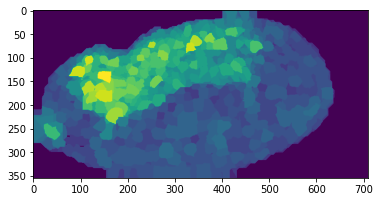

In [16]:
touching_neighbor_count = cle.count_touching_neighbors(touch_matrix)
cle.set_column(touching_neighbor_count, 0, 0)

tnc_map = cle.replace_intensities(cells, touching_neighbor_count)
show(tnc_map, title="neighbor count", use_napari=True)

[[0. 0. 9. ... 7. 6. 7.]]


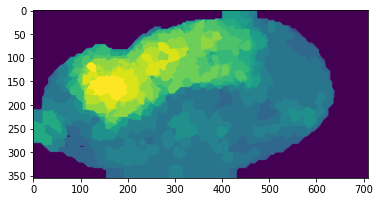

In [17]:
local_touching_neighbor_count = cle.median_of_touching_neighbors(touching_neighbor_count, touch_matrix)

print(local_touching_neighbor_count)
tnc_map = cle.replace_intensities(cells, local_touching_neighbor_count)
show(tnc_map, title="local median neighbor count", use_napari=True)

## Measure size

In [18]:
regionprops = cle.statistics_of_background_and_labelled_pixels(resampled, cells)

[[   0. 3578. 3089. ... 8486. 7314. 7980.]]


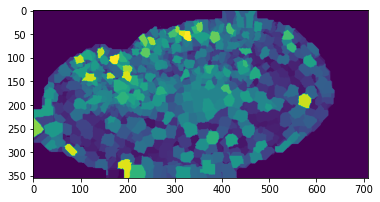

In [19]:
size = cle.push_zyx(np.asarray([[r.area for r in regionprops]]))

# ignore background
cle.set_column(size, 0, 0)

print(size)
size_map = cle.replace_intensities(cells, size)
show(size_map, title="size", use_napari=True)

## Measure mean intensity

[[  0.      520.4715  188.0861  ... 267.60345 234.75485 248.0163 ]]


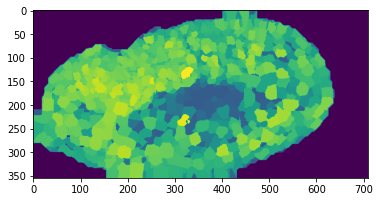

In [20]:
intensity = cle.push_zyx(np.asarray([[r.mean_intensity for r in regionprops]]))

# ignore background
cle.set_column(intensity, 0, 0)

print(intensity)
intensity_map = cle.replace_intensities(cells, intensity)
show(intensity_map, title="intensity", use_napari=True)

## Measure major_axis_length

[[ 0.       34.69095  34.5447   ... 38.01982  35.621105 36.602993]]


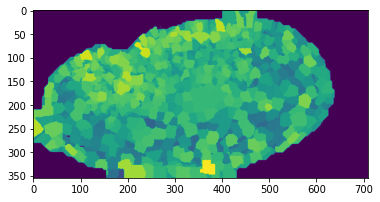

In [21]:
major_axis_length = cle.push_zyx(np.asarray([[r.major_axis_length for r in regionprops]]))

# ignore background
cle.set_column(major_axis_length, 0, 0)

print(major_axis_length)
major_axis_length_map = cle.replace_intensities(cells, major_axis_length)
show(major_axis_length_map, title="major_axis", use_napari=True)

# Plotting

In [22]:
print(nearest_neighbor_distance.shape)
print(touching_neighbor_count.shape)
print(local_stddev_nearest_neighbor_distance.shape)
print(intensity.shape)


(1, 1790)
(1, 1790)
(1, 1790)
(1, 1785)


## Ploting the raw measurements

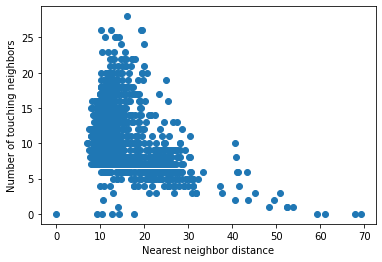

In [23]:
import matplotlib.pyplot as plt

plt.scatter(nearest_neighbor_distance, touching_neighbor_count)
plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

## Plotting the locally averaged measurements

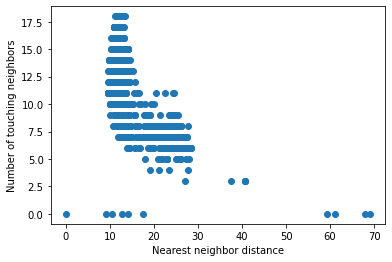

In [24]:
import matplotlib.pyplot as plt

plt.scatter(local_nearest_neighbor_distance, local_touching_neighbor_count)
plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

# Clustering

In [25]:
data = np.asarray([
    local_nearest_neighbor_distance[0], 
    local_touching_neighbor_count[0],
    local_stddev_nearest_neighbor_distance[0]
]).T
print(data.shape)

(1790, 3)


## Gaussian mixture model

In [26]:

num_classes = 3

from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
clf.fit(data)


GaussianMixture(n_components=3)

In [27]:
print(clf.means_, clf.covariances_)

[[22.08642695  7.26768784  1.35781947]
 [12.48114596 11.79692979  0.80363466]
 [11.22898393 13.01891471  0.41590064]] [[[ 3.64184173e+01 -5.91270113e+00 -1.61822445e+00]
  [-5.91270113e+00  2.76798733e+00  4.40408937e-01]
  [-1.61822445e+00  4.40408937e-01  9.99826859e-01]]

 [[ 9.80910018e-01  5.12613183e-01  4.49578494e-02]
  [ 5.12613183e-01  6.82158201e+00  2.65089471e-01]
  [ 4.49578494e-02  2.65089471e-01  1.16125109e-01]]

 [[ 5.40975490e-01  2.53587842e-01  4.85699738e-02]
  [ 2.53587842e-01  3.51370923e+00  1.07781410e-01]
  [ 4.85699738e-02  1.07781410e-01  1.56189443e-02]]]


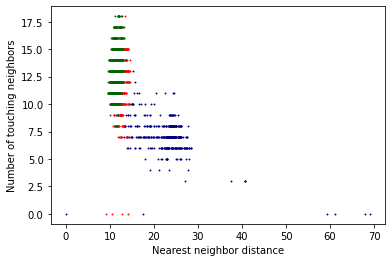

In [28]:
# inspired by https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

prediction = clf.predict(data)

for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[prediction == i, 0], data[prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

[[0. 1. 2. ... 1. 1. 1.]]


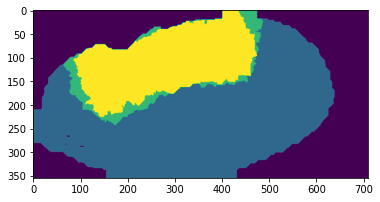

In [29]:
predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

# set background to 0
cle.set_column(predicition_vector, 0, 0)
print(predicition_vector)

prediction_map = cle.replace_intensities(cells, predicition_vector)
show(prediction_map, title="prediction", use_napari=True)

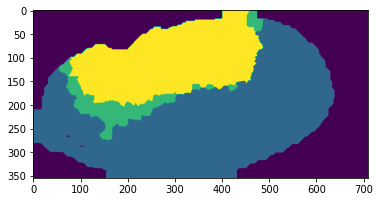

In [30]:
mode_prediction = cle.mode_of_touching_neighbors(predicition_vector, neighbors_of_neighbors)


prediction_map = cle.replace_intensities(cells, mode_prediction)
show(prediction_map, title="mode prediction", use_napari=True)

## K-means clustering

In [31]:
# inspired by https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

prediction = kmeans.predict(data)

print(prediction)

[1 0 1 ... 1 0 0]


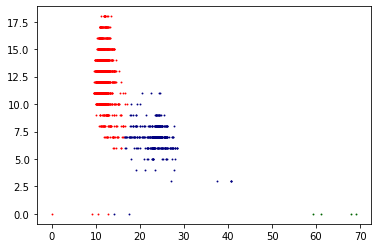

In [32]:
for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[prediction == i, 0], data[prediction == i, 1], .8, color=color)


[[0. 1. 2. ... 2. 1. 1.]]


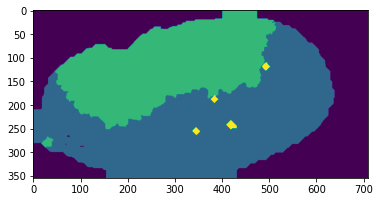

In [33]:
predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

# set background to 0
cle.set_column(predicition_vector, 0, 0)
print(predicition_vector)

prediction_map = cle.replace_intensities(cells, predicition_vector)
show(prediction_map, title="prediction", use_napari=True)